In [2182]:
import sklearn
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2183]:
# Import the data
tree = pd.read_csv('tree.csv')
tree['t'] = tree['t'].replace(to_replace=0, value=0.1)

vert_genes = pd.read_csv('vert_genes.csv')

## Part I: Simulation

In [2184]:
# Creating the graph

def create_graph(tree, alpha, beta, sigma_sq):
    G = nx.DiGraph()
    for _, row in tree.iterrows():
        if not pd.isna(row['Parent']):
            G.add_edge(int(row["Parent"]), int(row["Child"]), time = row["t"], a = alpha*row["t"], b = beta, variance = sigma_sq*row["t"])
            
    return G

G = create_graph(tree, alpha = 0, beta = 1, sigma_sq = 2500)

In [2185]:
def simulate_node_length_with_parameters(G, parent, simulated_lengths, alpha, beta, sigma_sq):
    for child in G.successors(parent):
        t = G[parent][child]['time']
        mean = alpha * t + beta * simulated_lengths[parent]
        std = np.sqrt(sigma_sq * t)
        simulated_lengths[child] = np.random.normal(mean, std)
        simulate_node_length_with_parameters(G, child, simulated_lengths, alpha, beta, sigma_sq)
    
    return simulated_lengths

In [2186]:
def simulate_data_for_learning(G, n, alpha, beta, sigma_sq, alpha_0, sigma_0_sq, root, learn_params = True, only_X = True):
    X_values = []
    Y_values = []
    
    all_nodes = list(G.nodes)  # Get all nodes in the graph

    for _ in range(n):
        simulated_lengths = {}
        
        # Simulate root node first
        simulated_lengths[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        
        # Simulate all other nodes recursively
        simulated_lengths = simulate_node_length_with_parameters(G, root, simulated_lengths, alpha, beta, sigma_sq)
        if only_X:
            leaf_nodes = [node for node in all_nodes if G.out_degree(node) == 0]
            simulated_x = [simulated_lengths[node] for node in leaf_nodes]
            
            X_values.append(simulated_x)
        else:
            X_values.append([simulated_lengths[node] for node in all_nodes])
            
        if learn_params:
            Y_values.append([alpha,beta,sigma_sq])
        else:
            Y_values.append(simulated_lengths[root])

    return np.array(X_values), np.array(Y_values)

learn_parameters = False

X, y = simulate_data_for_learning(G, 1000, alpha = 0.5, beta = 1, sigma_sq = 2500, alpha_0 = 50000, sigma_0_sq = 5000, root = 407, learn_params=learn_parameters)

print(X.shape)
print(y.shape)

print(y[10])

(1000, 204)
(1000,)
49965.035015860565


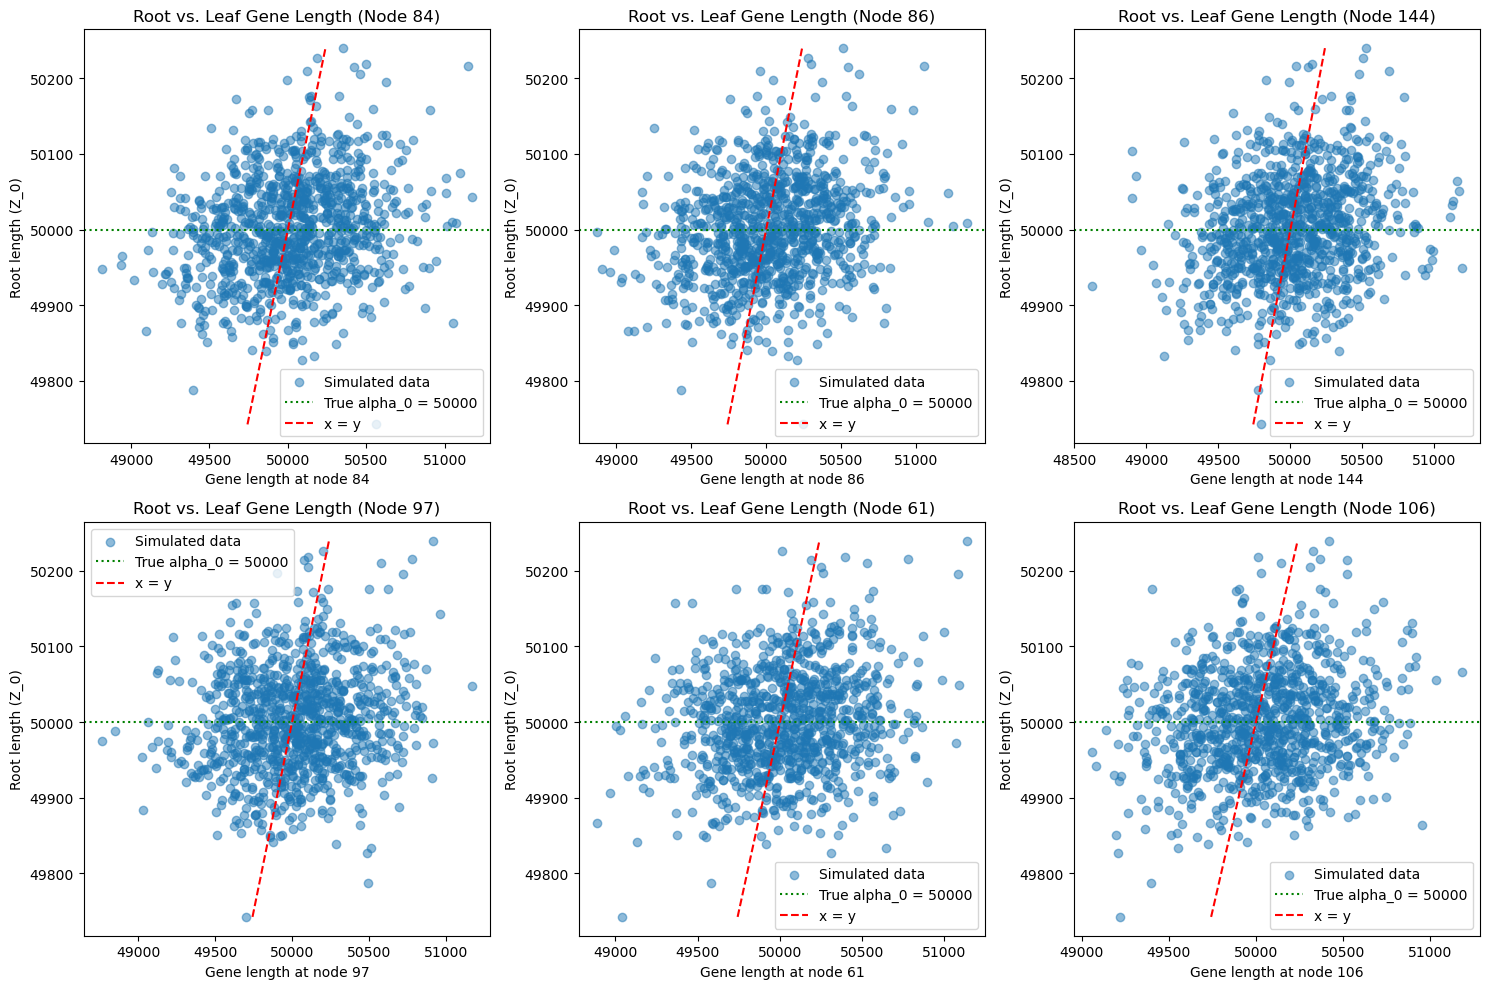

In [2187]:
def plotSimulation(X, y, nodes):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    for i, node in enumerate(nodes):
        ax = axes[i]
        ax.scatter(X[:, node], y, alpha=0.5, label="Simulated data")
        ax.axhline(y=50000, color='green', linestyle=':', label="True alpha_0 = 50000")
        ax.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label="x = y")
        ax.set_xlabel(f"Gene length at node {node}")
        ax.set_ylabel("Root length (Z_0)")
        ax.set_title(f"Root vs. Leaf Gene Length (Node {node})")
        ax.legend()

    plt.tight_layout()
    plt.show()

random_nodes = np.random.choice(X.shape[1], 6, replace=False)  # Select 6 random nodes
plotSimulation(X, y, random_nodes)

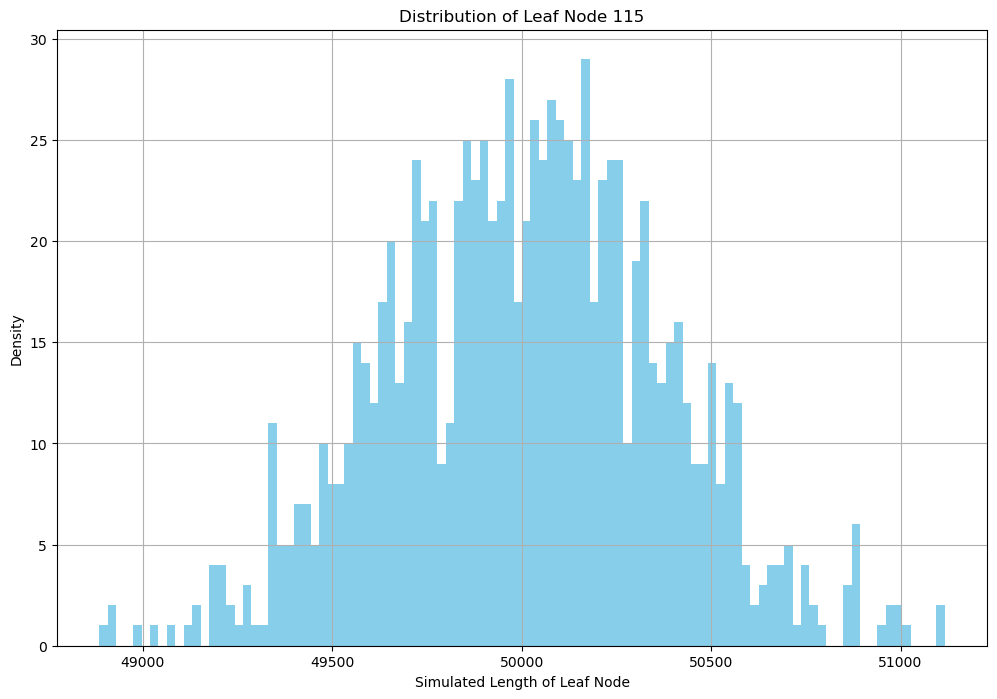

In [2188]:
def plot_leaf_distribution(X, leaf_index):
    leaf_data = X[:, leaf_index]  # Extract the column for this leaf

    # Plot histogram
    plt.figure(figsize=(12, 8))
    plt.hist(leaf_data, bins=100, color='skyblue')

    # Add labels
    plt.xlabel("Simulated Length of Leaf Node")
    plt.ylabel("Density")
    plt.grid(True)
    plt.title(f"Distribution of Leaf Node {leaf_index}")
    plt.show()


randomInt = np.random.randint(0, X.shape[1])
plot_leaf_distribution(X, randomInt)

In [2189]:
def linreg(samples, G):
    X,y = simulate_data_for_learning(G, samples, alpha = 0.5, beta = 1, sigma_sq = 2500, alpha_0 = 50000, sigma_0_sq = 5000, root = 407, learn_params=False)

    model = LinearRegression()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    model.fit(X_train, y_train)

    slope = model.coef_
    intercept = model.intercept_

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R^2: {r2}")

    return slope, intercept, y_pred, y_test


slope, intercept, y_pred, y_test = linreg(1000, G)

Mean Absolute Error: 56.20731641676157
Mean Squared Error: 4983.625757202502
Root Mean Squared Error: 70.59479978867071
R^2: 0.006391771346283326


In [2190]:
def compute_gamma(G):
    gamma = np.eye(len(G.nodes)) # Initialize gamma as an identity matrix

    # Iterate through the nodes in the graph
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            continue
        else:
            gamma[parent-1, node -1] = -G[parent][node]['b'] # Determine the dependency between parent and child nodes with -b
    return gamma

def compute_beta(G, alpha_0):
    beta = np.zeros((len(G.nodes), 1))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            beta[node-1] = alpha_0
            continue
        a = G[parent][node]['a'] # The constant term in the mean of the CPD
        beta[node-1] = a
        
    return beta

def compute_sigma(G, sigma_0_sq):
    sigma = np.zeros((len(G.nodes)))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            # Assign the default value for the root node
            sigma[node - 1] = sigma_0_sq
        else:
            # Access the edge attribute 'variance' only if parent exists
            variance = G[parent][node]['variance']
            sigma[node - 1] = variance
    return sigma

def compute_J_and_h(G, alpha, beta, sigma_sq, sigma_0_sq, alpha_0):
    
    beta = compute_beta(G, alpha_0)
    sigma = compute_sigma(G, sigma_0_sq)
    gamma = compute_gamma(G)

    J = np.sum([np.outer(gamma[:, i], gamma[:, i]) / sigma[i] for i in range(len(G))], axis=0)
    h = np.sum([(beta[i] / sigma[i]) * gamma[:, i] for i in range(len(G))], axis=0)
    return J, h



In [2191]:
def compute_clique_tree(G, Z_nodes = None):
    C = nx.Graph()

    G_working = G.copy()
    if Z_nodes is not None:
        leaves = [node for node in G_working.nodes 
                if G_working.out_degree(node) == 0 and node not in Z_nodes]
    else:
        leaves = [node for node in G_working.nodes if G_working.out_degree(node) == 0]

    G_working.remove_nodes_from(leaves)


    index = min(G_working.nodes) -1 if all(isinstance(n, int) for n in G_working.nodes) else 0

    for node in G_working.nodes:
        parent = node
        children = list(G_working.neighbors(parent))
        C.add_node(parent, variables=[parent])
        for child in children:
            pair_clique = index
            C.add_node(pair_clique, variables=[parent, child])
            C.add_edge(parent, pair_clique)
            C.add_edge(pair_clique, child)
            index = index - 1

    return C

C = compute_clique_tree(G)

### Matrix algebra implementation

In [2192]:
def get_sub_matrices(scope, X_values, J, h):
    X_indices = np.isin(scope, X_values)
    Z_indices = ~X_indices

    J_ZZ = J[Z_indices, :][:, Z_indices]
    J_ZX = J[Z_indices, :][:, X_indices]
    J_XZ = J_ZX.T
    J_XX = J[X_indices, :][:, X_indices]
    J_ZZ_inv = np.linalg.inv(J_ZZ)

    h_X = h[X_indices]
    h_Z = h[Z_indices]

    return J_ZZ, J_ZX, J_XZ, J_XX, J_ZZ_inv, h_X, h_Z

def get_conditional_distribution(J, h, X_values, X_indices, scope=None):
    if scope is None:
        scope = list(range(len(J)))  # zero-indexed scope

    # Keep only indices in scope
    X_indices = [i for i in X_indices if i in scope]
    X_values = np.array([X_values[i] for i in range(len(X_indices))])

    J_ZZ, J_ZX, J_XZ, J_XX, J_ZZ_inv, h_X, h_Z = get_sub_matrices(scope, X_indices, J, h)

    J_reduced = J_ZZ
    h_reduced = h_Z - J_ZX @ X_values

    Z_nodes = [i for i in scope if i not in X_indices]
    return J_reduced, h_reduced, Z_nodes


alpha = 0.5
beta = 1
sigma_sq = 2500

X_values = simulate_data_for_learning(G, 1, alpha=alpha, beta=beta, sigma_sq=sigma_sq, alpha_0=50000, sigma_0_sq=5000, root=407, learn_params=False, only_X=True)[0]

### Testing matrix algebra

In [2193]:
leaves = [node for node in G.nodes if G.out_degree(node) == 0]
X_indices = leaves

J, h = compute_J_and_h(G, alpha, beta, sigma_sq, 5000, 50000)

J_reduced, h_reduced, Z_nodes = get_conditional_distribution(J, h, X_values[0], X_indices)


Sigma = np.linalg.inv(J_reduced)
mu = Sigma @ h_reduced

random_index = np.random.choice(range(len(X_values[0])))
z = random_index
print(f"Predicted value for node 407: {mu[z]}")
print(f"Variance for node 407: {Sigma[z,z]}")
print(f"Actual value for node 407: {X_values[0][0]}")
print(f"True variance for node 407: {sigma_sq}")

Predicted value for node 407: 50006.849752188966
Variance for node 407: 5375.646937644098
Actual value for node 407: 50256.24888772967
True variance for node 407: 2500


## Part II : inference

In [2194]:
def marginalize_out(J, h, X_indices):
    scope = [i for i in range(1, len(J) + 1)]
    J_ZZ, J_ZX, J_XZ, J_XX, J_ZZ_inv, h_X, h_Z = get_sub_matrices(scope, X_indices, J, h)

    J_marg = J_ZZ - (J_ZX @ np.linalg.inv(J_XX) @ J_XZ)
    h_marg = h_Z - (J_ZX @ np.linalg.inv(J_XX) @ h_X)

    return J_marg, h_marg

In [2195]:

NoV = len([node for node in C.nodes if len(C.nodes[node]['variables']) == 1]) -1
maxIndex = max([node for node in C.nodes])
away_from_zero = maxIndex - NoV
minIndex = min([node for node in C.nodes if len(C.nodes[node]['variables']) == 1])

def mapping_GTM(index_in_graph):
    return index_in_graph - away_from_zero 

def mapping_MTG(index_in_matrix):
    return index_in_matrix + away_from_zero

### Rekuriv løsning

In [2196]:
def single_clique(G):
    leaves = [node for node in G.nodes if G.out_degree(node) == 0]
    H = G.copy()
    H.remove_nodes_from(leaves)
    H = H.to_undirected()
    return H

def compute_J_i_arrow_j(clique_tree, i, j, J, h, J_messages, h_messages):
    
    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)

    i_idx = mapping_GTM(i)
    j_idx = mapping_GTM(j)

    if not neighbors:
        J_messages[i_idx][j_idx] = -J[i_idx, j_idx] * J[j_idx, i_idx] / J[i_idx, i_idx]
    else:
        J_sum = sum(compute_J_i_arrow_j(clique_tree, k, i, J, h, J_messages, h_messages) for k in neighbors)
        J_messages[i_idx][j_idx] = -J[i_idx, j_idx] * J[j_idx, i_idx] / (J[i_idx, i_idx] + J_sum)

    return J_messages[i_idx][j_idx]


def compute_h_i_arrow_j(clique_tree, i, j, J, h, J_messages, h_messages):

    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)

    i_idx = mapping_GTM(i)
    j_idx = mapping_GTM(j)

    if not neighbors:
        h_messages[i_idx][j_idx] = -J[i_idx, j_idx] * h[i_idx] / J[i_idx, i_idx]
    else:
        J_sum = sum(compute_J_i_arrow_j(clique_tree, k, i, J, h, J_messages, h_messages) for k in neighbors)
        h_sum = sum(compute_h_i_arrow_j(clique_tree, k, i, J, h, J_messages, h_messages) for k in neighbors)
        Ji_backslash_j = J[i_idx, i_idx] + J_sum
        hi_backslash_j = h[i_idx] + h_sum
        h_messages[i_idx][j_idx] = (-J[i_idx, j_idx] * hi_backslash_j) / (Ji_backslash_j)

    return h_messages[i_idx][j_idx]

def inference_algorithm(G, alpha, beta, sigma_sq, alpha_0, X_indices, observed_X, Z):

    clique_tree = single_clique(G)
    J, h = compute_J_and_h(G, alpha, beta, sigma_sq, 5000, alpha_0)

    J_reduced, h_reduced, Z_nodes = get_conditional_distribution(J, h, observed_X, X_indices)
        
    J_messages = np.full(J_reduced.shape, np.nan)
    h_messages = np.full(J_reduced.shape, np.nan)

    Z_neighbors = list(clique_tree.neighbors(Z))
    Z_idx = mapping_GTM(Z)

    J_zz = J_reduced[Z_idx, Z_idx]

    sum_J = sum([compute_J_i_arrow_j(clique_tree, k, Z, J_reduced, h_reduced, J_messages, h_messages) for k in Z_neighbors])
    sum_h = sum([compute_h_i_arrow_j(clique_tree, k, Z, J_reduced, h_reduced, J_messages, h_messages) for k in Z_neighbors])

    J_hat_Z = J_zz + sum_J
    h_hat_Z = h_reduced[Z_idx] + sum_h


    return J_hat_Z, h_hat_Z

In [2197]:
def information_to_standard(clique_j, clique_h):

    z_hats = np.zeros_like(clique_h)
    z_vars = np.zeros_like(clique_h)

    for i in range(len(clique_j)):
        z_hats[i] = clique_h[i] / clique_j[i]
        z_vars[i] = 1 / clique_j[i]

    return z_hats, z_vars


def J_msg(clique_tree, i, j, J, h, J_messages, h_messages, sent):
    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)

    i_idx = mapping_GTM(i)
    j_idx = mapping_GTM(j)

    if not neighbors:
        # Leaf node — base case
        J_messages[i_idx][j_idx] = -J[i_idx, j_idx] * J[j_idx, i_idx] / J[i_idx, i_idx]
        sent[i_idx][j_idx] = True
        return

    # Collect required messages
    incoming_msgs = [J_messages[mapping_GTM(k)][i_idx] for k in neighbors]

    if any(np.isnan(m) for m in incoming_msgs):
        print("Attempted to compute message with missing dependencies")
        return  # Dependencies not ready — skip

    J_sum = sum(incoming_msgs)
    J_messages[i_idx][j_idx] = -J[i_idx, j_idx] * J[j_idx, i_idx] / (J[i_idx, i_idx] + J_sum)
    sent[i_idx][j_idx] = True

def h_msg(clique_tree, i, j, J, h, J_messages, h_messages, sent):
    neighbors = list(clique_tree.neighbors(i))
    neighbors.remove(j)

    i_idx = mapping_GTM(i)
    j_idx = mapping_GTM(j)

    if not neighbors:
        # Leaf node — base case
        h_messages[i_idx][j_idx] = -J[i_idx, j_idx] * h[i_idx] / J[i_idx, i_idx]
        sent[i_idx][j_idx] = True
        return

    J_incoming = [J_messages[mapping_GTM(k)][i_idx] for k in neighbors]
    h_incoming = [h_messages[mapping_GTM(k)][i_idx] for k in neighbors]

    if any(np.isnan(x) for x in J_incoming + h_incoming):
        print("Attempted to compute message with missing dependencies")
        return  # Dependencies not ready — skip

    J_sum = sum(J_incoming)
    h_sum = sum(h_incoming)

    Ji_backslash_j = J[i_idx, i_idx] + J_sum
    hi_backslash_j = h[i_idx] + h_sum

    h_messages[i_idx][j_idx] = -J[j_idx, i_idx] * hi_backslash_j / Ji_backslash_j
    sent[i_idx][j_idx] = True

def upward_pass(clique_tree, J, h, J_messages, h_messages, sent):
    queue = deque()

    # Start from leaves (nodes with degree 1)
    leaves = [node for node in clique_tree.nodes if clique_tree.degree[node] == 1]
    for leaf in leaves:
        queue.append(leaf)

    while queue:
        current = queue.popleft()
        for neighbor in clique_tree.neighbors(current):
            i = current
            j = neighbor
            i_idx = mapping_GTM(i)
            j_idx = mapping_GTM(j)

            if not sent[i_idx][j_idx]:
                # Check if all incoming messages to i (except from j) are ready
                deps_ready = all(
                    sent[mapping_GTM(k)][i_idx]
                    for k in clique_tree.neighbors(i) if k != j
                )
                if deps_ready:
                    J_msg(clique_tree, i, j, J, h, J_messages, h_messages, sent)
                    h_msg(clique_tree, i, j, J, h, J_messages, h_messages, sent)
                    queue.append(j)

    return J_messages, h_messages

def downward_pass(clique_tree, J, h, J_messages, h_messages, sent, root):
    queue = deque([root])

    while queue:
        current = queue.popleft()
        for neighbor in clique_tree.neighbors(current):
            i = current
            j = neighbor
            i_idx = mapping_GTM(i)
            j_idx = mapping_GTM(j)

            if not sent[i_idx][j_idx]:
                deps_ready = all(
                    sent[mapping_GTM(k)][i_idx]
                    for k in clique_tree.neighbors(i) if k != j
                )
                if deps_ready:
                    J_msg(clique_tree, i, j, J, h, J_messages, h_messages, sent)
                    h_msg(clique_tree, i, j, J, h, J_messages, h_messages, sent)
                    queue.append(j)

    return J_messages, h_messages

def compute_clique_beliefs(clique_tree, J, h, J_messages, h_messages):
    
    clique_j = np.zeros(shape=h.shape)
    clique_h = np.zeros(shape=h.shape)
    
    number_of_variables = len(h)
    for i in range(number_of_variables):
        J_i = J[i][i]
        h_i = h[i]

        graph_i = mapping_MTG(i)

        for neighbor in clique_tree.neighbors(graph_i):
            J_message = J_messages[mapping_GTM(neighbor)][i]
            h_message = h_messages[mapping_GTM(neighbor)][i]
            J_i += J_message
            h_i += h_message
        
        clique_j[i] = J_i
        clique_h[i] = h_i

    return clique_j, clique_h

def message_passing(G, alpha, beta, sigma_sq, alpha_0, sigma_0_sq, X_indices, observed_X):

    single_clique_tree = single_clique(G)
    J, h = compute_J_and_h(G, alpha, beta, sigma_sq, sigma_0_sq, alpha_0)

    J_reduced, h_reduced, Z_nodes = get_conditional_distribution(J, h, observed_X, X_indices)

        # Define full set of observed leaves (e.g., leaf nodes in G)
    expected_X_indices = set([node for node in G.nodes if G.out_degree(node) == 0])

    # Identify X variables that were not conditioned on (i.e. remain latent)
    remaining_x = [node for node in expected_X_indices if node not in X_indices and node in Z_nodes]

    if remaining_x:
        print("Marginalizing out remaining Xs:", remaining_x)
        J_reduced, h_reduced = marginalize_out(J_reduced, h_reduced, remaining_x)
        Z_nodes = [z for z in Z_nodes if z not in remaining_x]

    J_messages = np.full(J_reduced.shape, np.nan)
    h_messages = np.full(J_reduced.shape, np.nan)

    sent = np.zeros_like(J_messages, dtype=bool)

    J_msg_up, h_msg_up = upward_pass(single_clique_tree, J_reduced, h_reduced, J_messages, h_messages, sent)
    J_msg_down, h_msg_down = downward_pass(single_clique_tree, J_reduced, h_reduced, J_msg_up, h_msg_up, sent, 407)
    clique_j, clique_h = compute_clique_beliefs(single_clique_tree, J_reduced, h_reduced, J_msg_down, h_msg_down)
    print("Messages sent:", np.sum(sent), "/", sent.size)

    z_hats, z_vars = information_to_standard(clique_j, clique_h)
    return z_hats, z_vars, Z_nodes

alpha_0 = 50000
sigma_0_sq = 5000

alpha = 0.2
beta = 1.1
sigma_sq = 3000
G = create_graph(tree, alpha, beta, sigma_sq)
ZX_values = simulate_data_for_learning(G, 1, alpha=alpha, beta=beta, sigma_sq=sigma_sq, alpha_0=alpha_0, sigma_0_sq=sigma_0_sq, root=407, learn_params=False, only_X=False)[0]

print("Lenght of X_values: ", len(X_values[0]))
leaves = [node for node in G.nodes if G.out_degree(node) == 0]
X_indices = leaves
z_hats, z_vars, Z_nodes = message_passing(G, alpha, beta, sigma_sq, alpha_0, sigma_0_sq, X_indices, ZX_values[0])


randomValues = np.random.choice(range(len(z_hats)), 5, replace=False)

prnt = True
if prnt:

    for i in randomValues:
        print(f"Node {mapping_MTG(i)}:")
        print(f"Predicted mean: {z_hats[i]}")
        print(f"Predicted variance: {z_vars[i]}")
        print(f"True mean: {ZX_values[0][i]}")
        print(f"True variance: {sigma_sq * (1 + i / len(z_hats))}")
        print()

Lenght of X_values:  204
Messages sent: 404 / 41209
Node 247:
Predicted mean: 297014.3971573901
Predicted variance: 5955.831468385821
True mean: 229701.94366624538
True variance: 3620.6896551724135

Node 374:
Predicted mean: 98712.61045470383
Predicted variance: 5144.261825583146
True mean: 129244.36906525285
True variance: 5497.536945812808

Node 240:
Predicted mean: 128008.61180193775
Predicted variance: 1790.0663829333262
True mean: 336396.5157949013
True variance: 3517.241379310345

Node 259:
Predicted mean: 273819.1168222816
Predicted variance: 1940.1799083584829
True mean: 277366.43146757106
True variance: 3798.029556650246

Node 263:
Predicted mean: 202467.4607929061
Predicted variance: 5758.843486735467
True mean: 277848.94329648506
True variance: 3857.142857142857



In [2198]:
def split_gene_data(tree, vert_genes):
    data = pd.merge(tree, vert_genes, on='species', how='inner')
    rows = []
    for orth_id, group in data.groupby('orthId'):
        child_glength = dict(zip(group['Child'], group['glength']))
        rows.append({'orthId': orth_id, 'glength_dict': child_glength})

    return pd.DataFrame(rows)

real_data = split_gene_data(tree, vert_genes)


def inference_on_node(real_data, node_of_interest):
    rows = []
    for _, row in real_data.iterrows():
        orth_id = row['orthId']
        glength_dict = row['glength_dict']

        X_indices = list(glength_dict.keys())
        X_values = np.array(list(glength_dict.values()))

        z_hats, z_vars, Z_nodes = message_passing(G, alpha, beta, sigma_sq, alpha_0, sigma_0_sq, X_indices, X_values)


        idx = mapping_GTM(node_of_interest)
        mu = z_hats[idx]
        var = z_vars[idx]
    

        rows.append({'orthId': orth_id, 'mu': mu, 'var': var})

    return pd.DataFrame(rows)


node_of_interest = 407
real_results = inference_on_node(real_data, node_of_interest)

real_results

Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [90, 204]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [21, 105]
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [20, 96, 109, 112, 113, 115, 150, 154, 160, 179, 189, 192, 193, 199, 203, 204]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [92, 102, 103, 110, 111, 155, 156, 157]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [98, 118, 132]
Messages sent: 404 / 41209


,orthId,mu,var
0,1CPN2,46258.354555,1720.481782
1,1CQBX,36516.933607,1908.219564
2,1CQJ6,17204.565488,1720.481782
3,1CR8Z,20130.908854,1720.481782
4,1CTEU,20443.044358,1908.219564
5,1CTI9,31598.320629,1908.219564
6,1CYBB,27917.278357,1908.219564
7,1D0EM,17204.565488,1720.481782
8,1D1CF,25106.821098,1720.481782
9,1D3F1,17976.300656,1720.481782


## Part III: Learning

In [2199]:
def simulate_full_data(G, n_samples, alpha, beta, sigma_sq, alpha_0, sigma_0_sq):
    rows = []

    for _ in range(n_samples):
        simulated = {}
        simulated[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        simulate_node_length_with_parameters(G, root, simulated, alpha, beta, sigma_sq)

        for parent, child in G.edges:
            t = G[parent][child]['time']
            y = simulated[child]
            z = simulated[parent]
            rows.append({
                'Y': y,
                'Z': z,
                't': t
            })

    return pd.DataFrame(rows)

def estimate_alpha_beta_sigma2(data):
    X = data[['t', 'Z']]
    y = data['Y']

    weights = 1 / data['t']
    model = LinearRegression().fit(X, y, sample_weight=weights)
    alpha_hat = model.coef_[0]
    beta_hat = model.coef_[1]

    # Residual variance estimate of σ²

    residuals = y - model.predict(X)
    sigma_sq_hat = np.sum(weights * residuals**2) / len(y)

    return alpha_hat, beta_hat, sigma_sq_hat

root = 407
n = 1000
df = simulate_full_data(G, n, alpha=0.5, beta=1, sigma_sq=2500, alpha_0=50000, sigma_0_sq=5000)
alpha_hat, beta_hat, sigma_sq_hat = estimate_alpha_beta_sigma2(df)

print("Estimated alpha:", alpha_hat)
print("Estimated beta:", beta_hat)
print("Estimated sigma_sq:", sigma_sq_hat)

Estimated alpha: 0.45631404569006806
Estimated beta: 1.00002027051315
Estimated sigma_sq: 2497.49878491791


In [2200]:
def hard_assignment_EM(xs_lst, G, root, n_iter, alpha_init, beta_init, alpha0_init, sigma_sq_init, sigma_0_sq, trace = False):
    """
    xs_lst: list of dictionaries, each with observed values (t and Y) for a given sample
    G: DAG
    root: root node id (e.g., 407)
    n_iter: number of EM iterations
    alpha_init, beta_init, alpha0_init, sigma_sq_init: initial parameter values
    sigma_0_sq: fixed variance of the root prior
    """
    alpha = alpha_init
    beta = beta_init
    sigma_sq = sigma_sq_init
    alpha_0 = alpha0_init
    log_likelihoods = []

    for iter_num in range(n_iter):
        zs_list = []

        # -------- E-step: infer latent variables using message passing --------
        for x_dict in xs_lst:
            X_indices = list(x_dict.keys())
            X_values = np.array(list(x_dict.values()))

            z_hats, _, Z_nodes = message_passing(G, alpha, beta, sigma_sq, alpha_0, sigma_0_sq, X_indices, X_values)

            inferred = {}
            for node in G.nodes:
                if node in X_indices:
                    inferred[node] = x_dict[node]
                elif node in Z_nodes:
                    index = Z_nodes.index(node)
                    inferred[node] = z_hats[index]

            zs_list.append(inferred)

        # -------- M-step: re-estimate parameters from (Y, Z, t) triplets --------
        rows = []
        for x, z in zip(xs_lst, zs_list):
            for parent, child in G.edges:
                if child in x:
                    y = x[child]
                    z_parent = z[parent]
                    t = G[parent][child]['time']
                    rows.append({'Y': y, 'Z': z_parent, 't': t})

        df = pd.DataFrame(rows)
        alpha, beta, sigma_sq = estimate_alpha_beta_sigma2(df)
        alpha_0 = np.mean([z[mapping_GTM(root)] for z in zs_list])

        # -------- Log-likelihood (data only) --------
        if trace:
            log_likelihood = 0.0
            for row in rows:
                y = row['Y']
                z = row['Z']
                t = row['t']
                mean = alpha * t + beta * z
                var = sigma_sq * t
                ll = -0.5 * np.log(2 * np.pi * var) - 0.5 * ((y - mean) ** 2) / var
                log_likelihood += ll

            log_likelihoods.append(log_likelihood)

            print(f"--- Iteration {iter_num + 1} of {n_iter} ---")
            print("alpha:", alpha)
            print("beta:", beta)
            print("sigma_sq:", sigma_sq)
            print("alpha_0:", alpha_0)
            print("log-likelihood:", log_likelihood)

    return alpha, beta, sigma_sq, alpha_0, log_likelihoods



def make_partial_observations(G, simulated_full):
    leaves = [node for node in G.nodes if G.out_degree(node) == 0]
    partial_data = []

    for sample in simulated_full:
        partial = {leaf: sample[leaf] for leaf in leaves}
        partial_data.append(partial)

    return partial_data


def simulate_full_dataset(G, n_samples, alpha, beta, sigma_sq, alpha_0, sigma_0_sq, root):
    all_samples = []

    for _ in range(n_samples):
        sample = {}
        sample[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        simulate_node_length_with_parameters(G, root, sample, alpha, beta, sigma_sq)
        all_samples.append(sample)

    return all_samples


true_alpha = 0.5
true_beta = 1.0
true_sigma_sq = 2500
true_alpha_0 = 50000
true_sigma_0_sq = 5000
root = 407
n_samples = 1

# Simulate full data
full_data = simulate_full_dataset(G, n_samples, true_alpha, true_beta, true_sigma_sq, true_alpha_0, true_sigma_0_sq, root)

# Get partial observations (only leaf nodes)
xs_lst = make_partial_observations(G, full_data)

alpha, beta, sigma_sq, alpha_0, log_likelihood = hard_assignment_EM(
    xs_lst=xs_lst,
    G=G,
    root=407,
    n_iter=1,
    alpha_init=0,
    beta_init=1.2,
    alpha0_init=25000,
    sigma_sq_init=1000,
    sigma_0_sq=5000,
    trace=True
)

Messages sent: 404 / 41209
--- Iteration 1 of 1 ---
alpha: 2.5517243453953435
beta: -0.006336213938513531
sigma_sq: 16583.441553118704
alpha_0: 50183.55818674599
log-likelihood: -3104302.316753055


### Part III: Apply inference and learning algorithms to real data

In [2201]:
def estimate_parameters_for_real_data(real_data, n_iter, alpha_init, beta_init, alpha0_init, sigma_sq_init, sigma_0_sq, root):
    results = []

    for _, row in real_data.iterrows():
        orth_id = row['orthId']
        glength_dict = row['glength_dict']

        # Extract observed values (X_values) and their indices (X_indices)
        X_indices = sorted([i for i in glength_dict.keys()])
        X_values = np.array([glength_dict[i] for i in X_indices])

        print("Number of observed values: ", len(X_values))

        # Apply the EM algorithm to estimate parameters
        alpha, beta, sigma_sq, alpha_0, _ = hard_assignment_EM(
            xs_lst=[{idx: val for idx, val in zip(X_indices, X_values)}],
            G=G,
            root=root,
            n_iter=n_iter,
            alpha_init=alpha_init,
            beta_init=beta_init,
            alpha0_init=alpha0_init,
            sigma_sq_init=sigma_sq_init,
            sigma_0_sq=sigma_0_sq,
            trace=False
        )

        # Store the results
        results.append({
            'orthId': orth_id,
            'alpha': alpha,
            'beta': beta,
            'sigma_sq': sigma_sq,
            'alpha_0': alpha_0
        })

    return pd.DataFrame(results)

# Run the function on the real data
estimated_parameters = estimate_parameters_for_real_data(
    real_data=real_data,
    n_iter=10,
    alpha_init=0.5,
    beta_init=1.0,
    alpha0_init=50000,
    sigma_sq_init=2500,
    sigma_0_sq=5000,
    root=407
)

# Display the results
print(estimated_parameters)


Number of observed values:  203
Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Marginalizing out remaining Xs: [179]
Messages sent: 404 / 41209
Number of observed values:  204
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Messages sent: 404 / 41209
Number of observ

In [2202]:
estimated_parameters

,orthId,alpha,beta,sigma_sq,alpha_0
0,1CPN2,119.212452,0.990502,1.448406e+09,4568.0
1,1CQBX,-19.625230,1.028668,2.382949e+07,34954.0
2,1CQJ6,-268.005621,0.691778,4.193948e+07,8561.0
3,1CR8Z,-191.177210,0.199522,5.071160e+06,6660.0
4,1CTEU,64.006844,0.591304,3.463264e+06,2112.0
5,1CTI9,-16.760053,1.057275,9.741442e+06,23791.0
6,1CYBB,-98.814500,1.025213,1.234988e+08,15853.0
7,1D0EM,-54.465277,0.454330,1.013736e+07,3964.0
8,1D1CF,98.823415,0.136111,3.318707e+07,7387.0
9,1D3F1,-33.097108,0.666701,3.208421e+06,1881.0


In [2203]:
# Iterate over each row in the real_data DataFrame
for _, row in real_data.iterrows():
    orth_id = row['orthId']
    glength_dict = row['glength_dict']

    # Extract observed values (X_values) and their indices (X_indices)
    X_indices = list(glength_dict.keys())
    X_values = np.array(list(glength_dict.values()))

    # Compute the reduced precision matrix and potential vector
    J_reduced, h_reduced, Z_nodes = get_conditional_distribution(J, h, X_values, X_indices)

    print("size of J_reduced: ", J_reduced.shape)
    # Compute the posterior covariance matrix (Sigma) and mean (mu)
    Sigma = np.linalg.inv(J_reduced)
    mu = Sigma @ h_reduced

    # Map the root node index to the reduced matrix
    root_index = mapping_GTM(root)

    # Extract the posterior mean and variance for the root node
    posterior_mean = mu[root_index]
    posterior_variance = Sigma[root_index, root_index]

    print(f"Ortholog ID: {orth_id}")
    print(f"Posterior mean for root node: {posterior_mean}")
    print(f"Posterior variance for root node: {posterior_variance}")
    print("-" * 50)

size of J_reduced:  (204, 204)
Ortholog ID: 1CPN2
Posterior mean for root node: 30563.87502202885
Posterior variance for root node: 4191.610331774942
--------------------------------------------------
size of J_reduced:  (203, 203)
Ortholog ID: 1CQBX
Posterior mean for root node: 39982.716258990455
Posterior variance for root node: 1960.203886744951
--------------------------------------------------
size of J_reduced:  (205, 205)
Ortholog ID: 1CQJ6
Posterior mean for root node: 8453.937725606373
Posterior variance for root node: 3486.178264626228
--------------------------------------------------
size of J_reduced:  (205, 205)
Ortholog ID: 1CR8Z
Posterior mean for root node: 8619.928987713327
Posterior variance for root node: 3485.8027393580705
--------------------------------------------------
size of J_reduced:  (203, 203)
Ortholog ID: 1CTEU
Posterior mean for root node: 21205.099448828296
Posterior variance for root node: 1960.203886744951
-------------------------------------------